<b> Image Classification </b> <br>
In this project, you'll classify images from the CIFAR-10 dataset
(https://www.cs.toronto.edu/~kriz/cifar.html). The dataset consists of airplanes, dogs, cats, and other
objects. You'll preprocess the images, then train a convolutional neural network on all the samples.
The images need to be normalized and the labels need to be one-hot encoded. You'll get to apply
what you learned and build a convolutional, max pooling, dropout, and fully connected layers. At the
end, you'll get to see your neural network's predictions on the sample images.

In [1]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import io, os
from google.colab import files
import tarfile
import numpy as np

Using TensorFlow backend.


# Prepare Data

In [0]:
import requests 
image_url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
  
# URL of the image to be downloaded is defined as image_url 
r = requests.get(image_url) # create HTTP response object 
  
# send a HTTP request to the server and save 
# the HTTP response in a response object called r 
with open("cifar-10-python.tar.gz",'wb') as f: 
  
    # Saving received content as a png file in 
    # binary format 
  
    # write the contents of the response (r.content) 
    # to a new file in binary mode. 
    f.write(r.content) 

In [0]:
file = tarfile.open("cifar-10-python.tar.gz")
file.extractall()
file.close()

In [0]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [0]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer

In [0]:
def _load_label_names():
    """
    Load the label names from file
    """
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    """
    Load a batch of the dataset
    """
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']

    return features, labels


def display_stats(cifar10_dataset_folder_path, batch_id, sample_id):
    """
    Display Stats of the the dataset
    """
    batch_ids = list(range(1, 6))

    if batch_id not in batch_ids:
        print('Batch Id out of Range. Possible Batch Ids: {}'.format(batch_ids))
        return None

    features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_id)

    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}.  {} is out of range.'.format(len(features), batch_id, sample_id))
        return None

    print('\nStats of batch {}:'.format(batch_id))
    print('Samples: {}'.format(len(features)))
    print('Label Counts: {}'.format(dict(zip(*np.unique(labels, return_counts=True)))))
    print('First 20 Labels: {}'.format(labels[:20]))

    sample_image = features[sample_id]
    sample_label = labels[sample_id]
    label_names = _load_label_names()

    print('\nExample of Image {}:'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, label_names[sample_label]))
    plt.axis('off')
    plt.imshow(sample_image)


def _preprocess_and_save(normalize, one_hot_encode, features, labels, filename):
    """
    Preprocess data and save it to file
    """
    features = normalize(features)
    labels = one_hot_encode(labels)

    pickle.dump((features, labels), open(filename, 'wb'))


def preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode):
    """
    Preprocess Training and Validation Data
    """
    n_batches = 5
    valid_features = []
    valid_labels = []

    for batch_i in range(1, n_batches + 1):
        features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_i)
        validation_count = int(len(features) * 0.1)

        # Prprocess and save a batch of training data
        _preprocess_and_save(
            normalize,
            one_hot_encode,
            features[:-validation_count],
            labels[:-validation_count],
            'preprocess_batch_' + str(batch_i) + '.p')

        # Use a portion of training batch for validation
        valid_features.extend(features[-validation_count:])
        valid_labels.extend(labels[-validation_count:])

    # Preprocess and Save all validation data
    _preprocess_and_save(
        normalize,
        one_hot_encode,
        np.array(valid_features),
        np.array(valid_labels),
        'preprocess_validation.p')

    with open(cifar10_dataset_folder_path + '/test_batch', mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    # load the training data
    test_features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    test_labels = batch['labels']

    # Preprocess and Save all training data
    _preprocess_and_save(
        normalize,
        one_hot_encode,
        np.array(test_features),
        np.array(test_labels),
        'preprocess_training.p')


def batch_features_labels(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]


def load_preprocess_training_batch(batch_id, batch_size):
    """
    Load the Preprocessed Training data and return them in batches of <batch_size> or less
    """
    filename = 'preprocess_batch_' + str(batch_id) + '.p'
    features, labels = pickle.load(open(filename, mode='rb'))

    # Return the training data in batches of size <batch_size> or less
    return batch_features_labels(features, labels, batch_size)


def display_image_predictions(features, labels, predictions):
    n_classes = 10
    label_names = _load_label_names()
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(n_classes))
    label_ids = label_binarizer.inverse_transform(np.array(labels))

    fig, axies = plt.subplots(nrows=4, ncols=2)
    fig.tight_layout()
    fig.suptitle('Softmax Predictions', fontsize=20, y=1.1)

    n_predictions = 3
    margin = 0.05
    ind = np.arange(n_predictions)
    width = (1. - 2. * margin) / n_predictions

    for image_i, (feature, label_id, pred_indicies, pred_values) in enumerate(zip(features, label_ids, predictions.indices, predictions.values)):
        pred_names = [label_names[pred_i] for pred_i in pred_indicies]
        correct_name = label_names[label_id]

        axies[image_i][0].imshow(feature*255)
        axies[image_i][0].set_title(correct_name)
        axies[image_i][0].set_axis_off()

        axies[image_i][1].barh(ind + margin, pred_values[::-1], width)
        axies[image_i][1].set_yticks(ind + margin)
        axies[image_i][1].set_yticklabels(pred_names[::-1])
        axies[image_i][1].set_xticks([0, 0.5, 1.0])


In [0]:
features, labels = load_cfar10_batch("cifar-10-batches-py", 1)

In [9]:
features.shape

(10000, 32, 32, 3)

In [10]:
features[2].shape

(32, 32, 3)

In [11]:
labels[2]

9

In [12]:
len(labels)

10000

In [13]:
labels[0]

6

In [0]:
features2, labels2 = load_cfar10_batch("cifar-10-batches-py", 2)


Stats of batch 1:
Samples: 10000
Label Counts: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
First 20 Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6]

Example of Image 2000:
Image - Min Value: 19 Max Value: 255
Image - Shape: (32, 32, 3)
Label - Label Id: 7 Name: horse


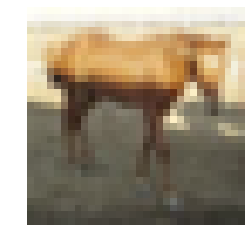

In [15]:
display_stats("cifar-10-batches-py", 1, 2000)


Stats of batch 1:
Samples: 10000
Label Counts: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
First 20 Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6]

Example of Image 2001:
Image - Min Value: 0 Max Value: 255
Image - Shape: (32, 32, 3)
Label - Label Id: 9 Name: truck


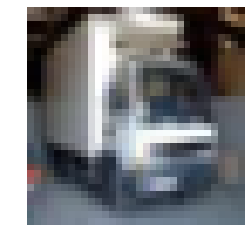

In [16]:
display_stats("cifar-10-batches-py", 1, 2001)

# Build Model

In [0]:
# initialize the CNN
classifier = Sequential()

In [18]:
# Convolution Layer
classifier.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu'))

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
# Pooling Layer
classifier.add(MaxPooling2D(pool_size=(2, 2)))

In [0]:
# Add 2nd convolution Layer
classifier.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))

In [0]:
# Add 2n Pooling Layer
classifier.add(MaxPooling2D(pool_size=(2, 2)))

In [0]:
# Flatten the table before providing it to ANN
classifier.add(Flatten())

In [0]:
# Add full network i.e. ANN
classifier.add(Dense(units=128, activation='relu'))
classifier.add(Dense(units=10, activation='softmax'))

In [0]:
# Compile the CNN model
classifier.compile(optimizer= 'adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [25]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
labelencoder_y_1 = LabelEncoder()
labelsOneHot = labelencoder_y_1.fit_transform(labels)
labelsOneHot
labelsOneHot2 = labelencoder_y_1.fit_transform(labels2)
labelsOneHot2

array([1, 6, 6, ..., 7, 2, 5])

In [27]:
classifier.fit(x=features, y=labelsOneHot, batch_size=100, epochs=5, validation_data=(features2, labelsOneHot2), shuffle=True)

Train on 10000 samples, validate on 10000 samples
Epoch 1/5
10000/10000 [==============================] - 15s 2ms/step - loss: 14.4982 - acc: 0.1005 - val_loss: 14.5321 - val_acc: 0.0984
Epoch 2/5
10000/10000 [==============================] - 16s 2ms/step - loss: 14.4982 - acc: 0.1005 - val_loss: 14.5321 - val_acc: 0.0984
Epoch 3/5
10000/10000 [==============================] - 16s 2ms/step - loss: 14.4982 - acc: 0.1005 - val_loss: 14.5321 - val_acc: 0.0984
Epoch 4/5
10000/10000 [==============================] - 16s 2ms/step - loss: 14.4982 - acc: 0.1005 - val_loss: 14.5321 - val_acc: 0.0984
Epoch 5/5
10000/10000 [==============================] - 16s 2ms/step - loss: 14.4982 - acc: 0.1005 - val_loss: 14.5321 - val_acc: 0.0984


# Prediction or Scoring

In [0]:
features3, labels3 = load_cfar10_batch("cifar-10-batches-py", 3)
labelsOneHot3 = labelencoder_y_1.fit_transform(labels3)

In [0]:
yPredicted = classifier.predict(features3, batch_size=100)

In [0]:
misclassified = 0
objectsIdentified = list()
for i in range(len(labelsOneHot3)):
  prediction = np.where(yPredicted[200]==1)[0][0]
  objectsIdentified.append(prediction)
  if(prediction != labelsOneHot3[i]):
    misclassified += 1

In [58]:
print('mis classification rate is {}%'.format(misclassified/len(labelsOneHot3)*100))

mis classification rate is 90.06%


In [60]:
print('values predicted by the model are: {}'.format(set(objectsIdentified)))

values predicted by the model are: {0}



Stats of batch 1:
Samples: 10000
Label Counts: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
First 20 Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6]

Example of Image 29:
Image - Min Value: 2 Max Value: 254
Image - Shape: (32, 32, 3)
Label - Label Id: 0 Name: airplane


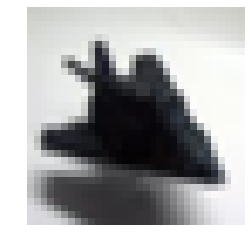

In [90]:
display_stats("cifar-10-batches-py", 1, 29)

<b>  This means model is predicting only one image all the time with label ID as 0 and its airoplane and not at all predicting any other image

<B> This means we will have to tune this model a lot to improve the performance. I will do it later as exploration and not in this project.